# Exploratory Data Analysis: CTA Transit Anomaly Detection

This notebook performs comprehensive exploratory data analysis on Chicago Transit Authority (CTA) train data and implements multiple anomaly detection methods.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
from math import radians, cos, sin, asin, sqrt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure matplotlib
plt.rcParams.update({
    "font.family": "serif",
    "figure.figsize": (12, 8),
    "axes.grid": True,
    "grid.alpha": 0.3
})

# CTA Line Colors (official colors)
CTA_LINE_COLORS = {
    'red': '#C60C30',      # Red Line
    'blue': '#00A1DE',     # Blue Line  
    'brn': '#62361B',      # Brown Line (abbreviated as 'brn' in data)
    'g': '#009639',        # Green Line (abbreviated as 'g' in data)
    'org': '#F9461C',      # Orange Line (abbreviated as 'org' in data)
    'p': '#522398',        # Purple Line (abbreviated as 'p' in data)
    'pink': '#E27EA6',     # Pink Line
    'y': '#F9E300'         # Yellow Line (abbreviated as 'y' in data)
}

# Set pandas display options
pd.set_option('display.max_columns', 50)

## 1. Data Loading and Initial Inspection

In [3]:
# Debug: Check current working directory and test paths
import os
print(f"Current working directory: {os.getcwd()}")
print(f"Files in current directory: {os.listdir('.')}")

# Test different database paths
possible_paths = [
    "../../data/cta_database.db",
    "data/cta_database.db",
    "../data/cta_database.db"
]

DB_PATH = None
for path in possible_paths:
    if os.path.exists(path):
        print(f"✓ Found database at: {path}")
        DB_PATH = path
        break
    else:
        print(f"✗ Not found: {path}")

if DB_PATH is None:
    raise FileNotFoundError("Could not find database file")

# Load data from database
conn = sqlite3.connect(DB_PATH)
query = "SELECT * FROM train_positions"
df = pd.read_sql_query(query, conn)
conn.close()

print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
display(df.head())
print(f"\nData info:")
df.info()

Current working directory: /Users/gauravkhanal/Documents/transit_anomaly/src/notebooks
Files in current directory: ['03-LSTM-Training.ipynb', '02-Modeling.ipynb.backup', '01-EDA.ipynb', 'models', 'mlruns', '.virtual_documents', '.ipynb_checkpoints', '02-Modeling.ipynb', 'lightning_logs']
✓ Found database at: ../../data/cta_database.db
Dataset shape: (10746, 11)

First 5 rows:


,id,fetch_timestamp,run_number,route_name,destination_name,next_station_name,arrival_time,is_delayed,latitude,longitude,heading
0,1,1756752760,803,red,Howard,Argyle,1756727567,0,41.96914,-87.65849,0
1,2,1756752760,804,red,Howard,Sheridan,1756727579,0,41.95377,-87.65493,271
2,3,1756752760,805,red,Howard,Fullerton,1756727702,0,41.91065,-87.64918,305
3,4,1756752760,806,red,Howard,Clark/Division,1756727594,0,41.90394,-87.62893,273
4,5,1756752760,808,red,Howard,79th,1756727596,0,41.74410,-87.62499,358



Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10746 entries, 0 to 10745
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10746 non-null  int64  
 1   fetch_timestamp    10746 non-null  int64  
 2   run_number         10746 non-null  object 
 3   route_name         10746 non-null  object 
 4   destination_name   10746 non-null  object 
 5   next_station_name  10746 non-null  object 
 6   arrival_time       10746 non-null  int64  
 7   is_delayed         10746 non-null  int64  
 8   latitude           10746 non-null  float64
 9   longitude          10746 non-null  float64
 10  heading            10746 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 923.6+ KB


In [4]:
# Basic statistics
print(f"Dataset Summary:")
print(f"Total records: {len(df):,}")
print(f"Date range: {pd.to_datetime(df['fetch_timestamp'], unit='s').min()} to {pd.to_datetime(df['fetch_timestamp'], unit='s').max()}")
print(f"Unique routes: {df['route_name'].nunique()}")
print(f"Unique trains: {df['run_number'].nunique()}")
print(f"Records with delays: {df['is_delayed'].sum():,} ({df['is_delayed'].mean():.1%})")

print(f"\nRecords by route:")
route_counts = df['route_name'].value_counts()
print(route_counts)

Dataset Summary:
Total records: 10,746
Date range: 2025-09-01 18:52:40 to 2025-09-02 09:47:34
Unique routes: 8
Unique trains: 178
Records with delays: 76 (0.7%)

Records by route:
route_name
blue    3015
red     2560
g       1909
brn     1102
org      928
pink     880
p        265
y         87
Name: count, dtype: int64


## 2. Feature Engineering

In [5]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points on earth (in km)"""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371 * c  # Earth radius in km

# Sort by train and timestamp for speed calculation
df_sorted = df.sort_values(['run_number', 'fetch_timestamp']).copy()

# Calculate speed for each train
df_sorted['prev_lat'] = df_sorted.groupby('run_number')['latitude'].shift(1)
df_sorted['prev_lon'] = df_sorted.groupby('run_number')['longitude'].shift(1)
df_sorted['prev_timestamp'] = df_sorted.groupby('run_number')['fetch_timestamp'].shift(1)

# Calculate distance and time differences
mask = df_sorted[['prev_lat', 'prev_lon', 'prev_timestamp']].notna().all(axis=1)
df_sorted.loc[mask, 'distance_km'] = df_sorted.loc[mask].apply(
    lambda row: haversine_distance(row['prev_lat'], row['prev_lon'], row['latitude'], row['longitude']), axis=1
)
df_sorted.loc[mask, 'time_diff_hours'] = (df_sorted.loc[mask, 'fetch_timestamp'] - df_sorted.loc[mask, 'prev_timestamp']) / 3600

# Calculate speed (km/h), handle division by zero
df_sorted.loc[mask, 'speed_kmh'] = df_sorted.loc[mask, 'distance_km'] / df_sorted.loc[mask, 'time_diff_hours']
df_sorted.loc[df_sorted['time_diff_hours'] == 0, 'speed_kmh'] = 0

# Clean unrealistic speeds (> 200 km/h for trains is unrealistic)
df_sorted.loc[df_sorted['speed_kmh'] > 200, 'speed_kmh'] = np.nan

print(f"Speed calculation complete.")
print(f"Records with valid speed data: {df_sorted['speed_kmh'].notna().sum():,}")
print(f"Speed statistics (km/h):")
print(df_sorted['speed_kmh'].describe())

Speed calculation complete.
Records with valid speed data: 10,474
Speed statistics (km/h):
count    10474.000000
mean        28.121881
std         26.311362
min          0.000000
25%          8.416508
50%         24.008919
75%         40.695060
max        198.925500
Name: speed_kmh, dtype: float64


In [6]:
# Add time-based features
df_sorted['datetime'] = pd.to_datetime(df_sorted['fetch_timestamp'], unit='s')
df_sorted['hour_of_day'] = df_sorted['datetime'].dt.hour
df_sorted['day_of_week'] = df_sorted['datetime'].dt.dayofweek
df_sorted['is_weekend'] = df_sorted['day_of_week'].isin([5, 6])
df_sorted['is_rush_hour'] = df_sorted['hour_of_day'].isin([7, 8, 9, 17, 18, 19])

print(f"Time features added successfully")
print(f"Data spans {df_sorted['datetime'].dt.date.nunique()} unique days")
print(f"Rush hour records: {df_sorted['is_rush_hour'].sum():,} ({df_sorted['is_rush_hour'].mean():.1%})")
print(f"Weekend records: {df_sorted['is_weekend'].sum():,} ({df_sorted['is_weekend'].mean():.1%})")

Time features added successfully
Data spans 2 unique days
Rush hour records: 6,907 (64.3%)
Weekend records: 0 (0.0%)


## 3. Temporal Patterns Analysis

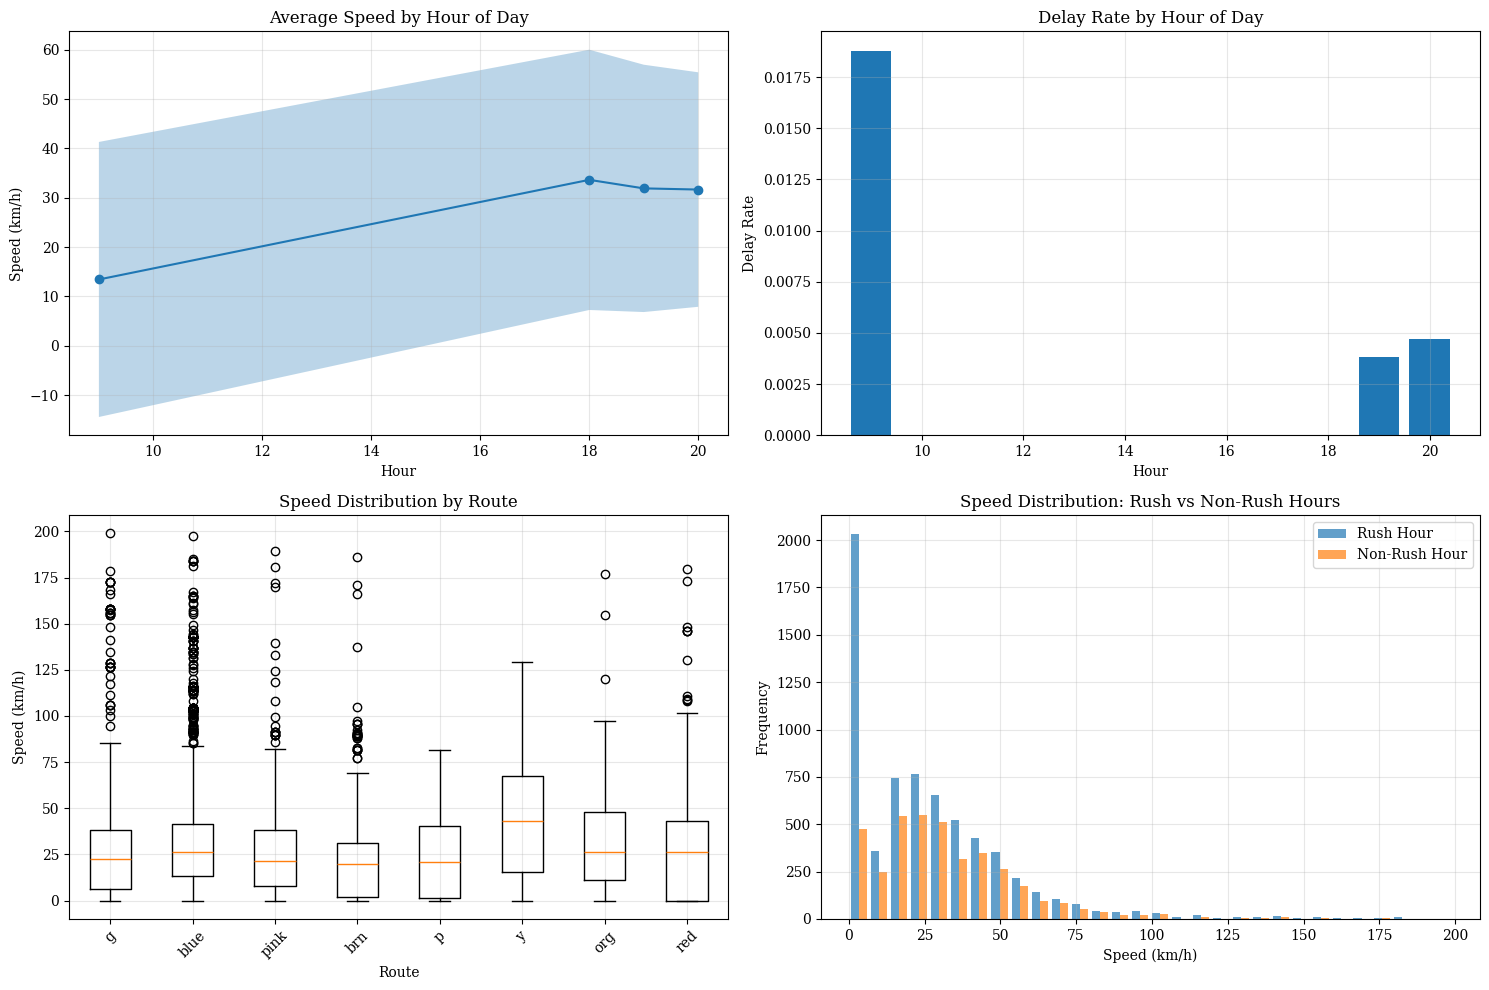

In [7]:
# Create temporal analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Speed by hour of day
hourly_speed = df_sorted.groupby('hour_of_day')['speed_kmh'].agg(['mean', 'std']).reset_index()
axes[0,0].plot(hourly_speed['hour_of_day'], hourly_speed['mean'], marker='o')
axes[0,0].fill_between(hourly_speed['hour_of_day'], 
                       hourly_speed['mean'] - hourly_speed['std'],
                       hourly_speed['mean'] + hourly_speed['std'], alpha=0.3)
axes[0,0].set_title('Average Speed by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Speed (km/h)')

# Delay rate by hour
hourly_delays = df_sorted.groupby('hour_of_day')['is_delayed'].mean()
axes[0,1].bar(hourly_delays.index, hourly_delays.values)
axes[0,1].set_title('Delay Rate by Hour of Day')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Delay Rate')

# Speed distribution by route
route_speeds = [df_sorted[df_sorted['route_name'] == route]['speed_kmh'].dropna() 
                for route in df_sorted['route_name'].unique()]
axes[1,0].boxplot(route_speeds, labels=df_sorted['route_name'].unique())
axes[1,0].set_title('Speed Distribution by Route')
axes[1,0].set_xlabel('Route')
axes[1,0].set_ylabel('Speed (km/h)')
axes[1,0].tick_params(axis='x', rotation=45)

# Rush hour vs non-rush hour speeds
rush_speeds = df_sorted[df_sorted['is_rush_hour']]['speed_kmh'].dropna()
non_rush_speeds = df_sorted[~df_sorted['is_rush_hour']]['speed_kmh'].dropna()
axes[1,1].hist([rush_speeds, non_rush_speeds], bins=30, alpha=0.7, 
               label=['Rush Hour', 'Non-Rush Hour'])
axes[1,1].set_title('Speed Distribution: Rush vs Non-Rush Hours')
axes[1,1].set_xlabel('Speed (km/h)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 4. Basic Spatial Analysis

In [8]:
# Load Chicago map if available
try:
    chicago_map = gpd.read_file("../../geo_data/Boundaries_-_City_20250823.geojson")
    map_available = True
    print("Chicago map loaded successfully")
except:
    map_available = False
    print("Chicago map not available - will create basic plots")

Chicago map loaded successfully


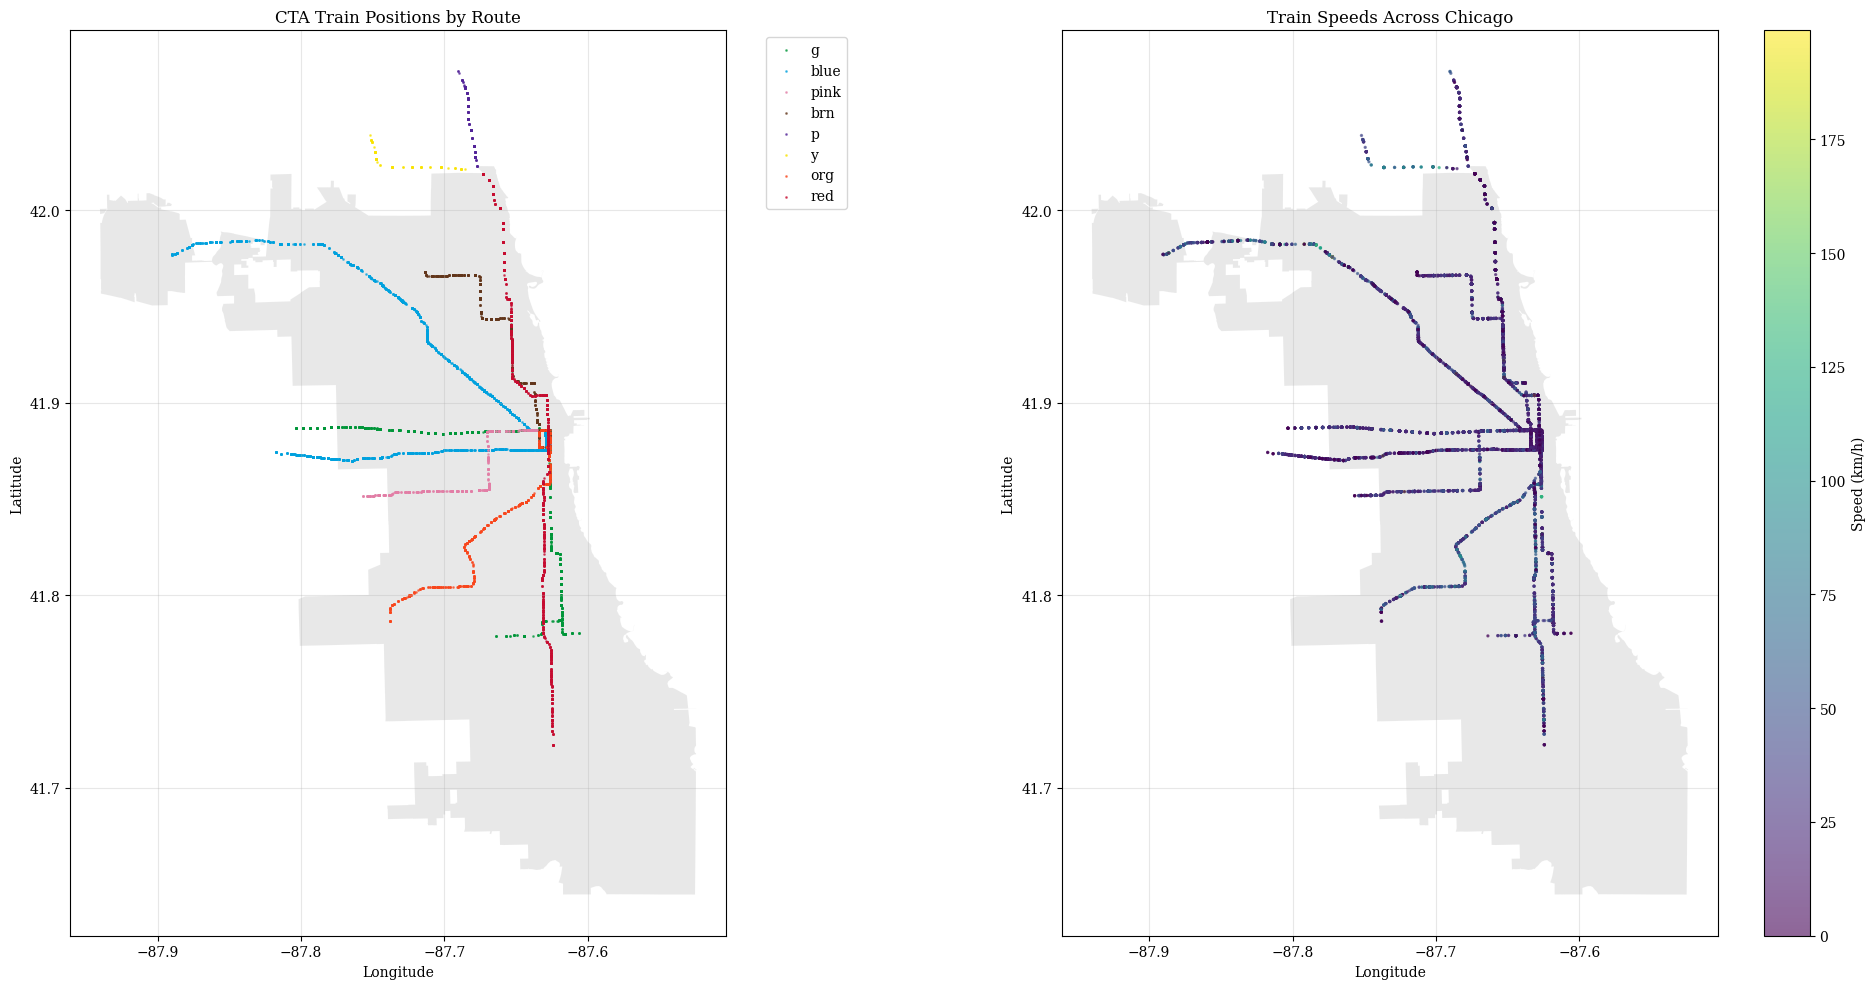

In [9]:
# Create basic spatial visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Train positions by route
if map_available:
    chicago_map.plot(ax=axes[0], color='lightgray', alpha=0.5)

for route in df_sorted['route_name'].unique():
    route_data = df_sorted[df_sorted['route_name'] == route]
    color = CTA_LINE_COLORS.get(route, '#888888')  # Default gray for unknown routes
    axes[0].scatter(route_data['longitude'], route_data['latitude'], 
                   label=route, alpha=0.6, s=1, color=color)
axes[0].set_title('CTA Train Positions by Route')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot 2: Speed distribution on map
if map_available:
    chicago_map.plot(ax=axes[1], color='lightgray', alpha=0.5)

speed_data = df_sorted[df_sorted['speed_kmh'].notna()]
scatter = axes[1].scatter(speed_data['longitude'], speed_data['latitude'], 
                         c=speed_data['speed_kmh'], cmap='viridis', alpha=0.6, s=2)
axes[1].set_title('Train Speeds Across Chicago')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(scatter, ax=axes[1], label='Speed (km/h)')

plt.tight_layout()
plt.show()

## 5. Anomaly Detection Methods Comparison

In [10]:
# Prepare data for anomaly detection
df_features = df_sorted[df_sorted['speed_kmh'].notna()].copy()

print(f"Prepared {len(df_features):,} records for anomaly detection")
print(f"Features available: speed, location, time, delays")

# Prepare feature matrix for unsupervised methods
feature_cols = ['speed_kmh', 'hour_of_day', 'day_of_week', 'is_delayed', 'heading', 'latitude', 'longitude']
X_unsupervised = df_features[feature_cols].fillna(df_features[feature_cols].median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsupervised)

print(f"Feature matrix prepared: {X_scaled.shape}")

Prepared 10,474 records for anomaly detection
Features available: speed, location, time, delays
Feature matrix prepared: (10474, 7)


### 5.1 Z-Score

In [11]:
# Method 1: Z-Score Anomaly Detection
def detect_zscore_anomalies(group, threshold=2.5):
    """Detect anomalies within a group using Z-score"""
    if len(group) < 2:
        return pd.Series([False] * len(group), index=group.index)
    
    speeds = group['speed_kmh'].fillna(group['speed_kmh'].median())
    if speeds.std() == 0:
        return pd.Series([False] * len(group), index=group.index)
    
    z_scores = np.abs(stats.zscore(speeds))
    return z_scores > threshold

# Debug: Check data distribution first
print(f"Speed data analysis:")
print(f"Total records with speed: {len(df_features):,}")
print(f"Speed range: {df_features['speed_kmh'].min():.1f} - {df_features['speed_kmh'].max():.1f} km/h")
print(f"Speed mean: {df_features['speed_kmh'].mean():.1f} km/h")
print(f"Speed std: {df_features['speed_kmh'].std():.1f} km/h")

# Check group sizes
route_group_sizes = df_features.groupby('route_name').size()
hour_group_sizes = df_features.groupby(['route_name', 'hour_of_day']).size()

print(f"\nGrouping analysis:")
print(f"Routes: {len(route_group_sizes)} groups, sizes: {route_group_sizes.min()}-{route_group_sizes.max()}")
print(f"Route+Hour: {len(hour_group_sizes)} groups, sizes: {hour_group_sizes.min()}-{hour_group_sizes.max()}")
print(f"Route+Hour groups with 5+ samples: {(hour_group_sizes >= 5).sum()}")

# Use route-only grouping for more reliable results
print(f"\nUsing route-only grouping for better sample sizes")
df_features['zscore_anomaly'] = df_features.groupby('route_name').apply(
    detect_zscore_anomalies
).reset_index(level=0, drop=True)

zscore_count = df_features['zscore_anomaly'].sum()
zscore_rate = df_features['zscore_anomaly'].mean()

print(f"\nZ-Score Results: {zscore_count:,} anomalies ({zscore_rate:.2%})")

# If still no anomalies, try a simpler approach
if zscore_count == 0:
    print("\nTrying global Z-score approach...")
    global_z_scores = np.abs(stats.zscore(df_features['speed_kmh']))
    df_features['zscore_anomaly'] = global_z_scores > 2.0  # Lower threshold
    
    zscore_count = df_features['zscore_anomaly'].sum()
    zscore_rate = df_features['zscore_anomaly'].mean()
    print(f"Global Z-Score Results: {zscore_count:,} anomalies ({zscore_rate:.2%})")

Speed data analysis:
Total records with speed: 10,474
Speed range: 0.0 - 198.9 km/h
Speed mean: 28.1 km/h
Speed std: 26.3 km/h

Grouping analysis:
Routes: 8 groups, sizes: 83-2925
Route+Hour: 32 groups, sizes: 4-1162
Route+Hour groups with 5+ samples: 31

Using route-only grouping for better sample sizes

Z-Score Results: 0 anomalies (nan%)

Trying global Z-score approach...
Global Z-Score Results: 402 anomalies (3.84%)


### 5.2 Isolation Forest

In [12]:
# Method 2: Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,
    random_state=42,
    n_estimators=100
)

df_features['iso_anomaly'] = iso_forest.fit_predict(X_scaled) == -1

iso_count = df_features['iso_anomaly'].sum()
iso_rate = df_features['iso_anomaly'].mean()

print(f"Isolation Forest Results: {iso_count:,} anomalies ({iso_rate:.2%})")

Isolation Forest Results: 524 anomalies (5.00%)


### 5.3 Local Outlier Factor

In [13]:
# Method 3: Local Outlier Factor
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05
)

df_features['lof_anomaly'] = lof.fit_predict(X_scaled) == -1

lof_count = df_features['lof_anomaly'].sum()
lof_rate = df_features['lof_anomaly'].mean()

print(f"Local Outlier Factor Results: {lof_count:,} anomalies ({lof_rate:.2%})")

Local Outlier Factor Results: 524 anomalies (5.00%)


### 5.4 One-Class SVM

In [14]:
# Method 4: One-Class SVM
svm = OneClassSVM(
    gamma='scale',
    nu=0.05
)

df_features['svm_anomaly'] = svm.fit_predict(X_scaled) == -1

svm_count = df_features['svm_anomaly'].sum()
svm_rate = df_features['svm_anomaly'].mean()

print(f"One-Class SVM Results: {svm_count:,} anomalies ({svm_rate:.2%})")

One-Class SVM Results: 521 anomalies (4.97%)


### 5.5 Ensemble Method

In [15]:
# Create ensemble method
methods = ['zscore_anomaly', 'iso_anomaly', 'lof_anomaly', 'svm_anomaly']
working_methods = []

# Check which methods found anomalies
for method in methods:
    count = df_features[method].sum()
    if count > 0:
        working_methods.append(method)
    else:
        print(f"Warning: {method} detected 0 anomalies")

print(f"\nUsing {len(working_methods)} working methods: {working_methods}")

if len(working_methods) >= 2:
    # Ensemble: anomaly if detected by 2+ methods
    df_features['ensemble_anomaly'] = (df_features[working_methods].sum(axis=1) >= 2)
    
    # High confidence: detected by 3+ methods (or all if < 3)
    min_for_high_conf = min(3, len(working_methods))
    df_features['high_confidence_anomaly'] = (df_features[working_methods].sum(axis=1) >= min_for_high_conf)
    
    ensemble_count = df_features['ensemble_anomaly'].sum()
    ensemble_rate = df_features['ensemble_anomaly'].mean()
    high_conf_count = df_features['high_confidence_anomaly'].sum()
    high_conf_rate = df_features['high_confidence_anomaly'].mean()
    
    print(f"\nEnsemble Results:")
    print(f"Ensemble (2+ methods): {ensemble_count:,} ({ensemble_rate:.2%})")
    print(f"High confidence ({min_for_high_conf}+ methods): {high_conf_count:,} ({high_conf_rate:.2%})")
    
    # Check overlap with official delays
    if ensemble_count > 0:
        delay_overlap = df_features[df_features['ensemble_anomaly'] & df_features['is_delayed']].shape[0]
        print(f"Ensemble delay overlap: {delay_overlap} ({delay_overlap/ensemble_count:.1%})")
else:
    print("Warning: Not enough working methods for ensemble")
    best_method = working_methods[0] if working_methods else 'iso_anomaly'
    df_features['ensemble_anomaly'] = df_features[best_method]
    df_features['high_confidence_anomaly'] = df_features[best_method]


Using 4 working methods: ['zscore_anomaly', 'iso_anomaly', 'lof_anomaly', 'svm_anomaly']

Ensemble Results:
Ensemble (2+ methods): 492 (4.70%)
High confidence (3+ methods): 168 (1.60%)
Ensemble delay overlap: 63 (12.8%)


## 6. Comprehensive Anomaly Visualization


=== ANOMALY DETECTION COMPARISON ===
                 Method  Count    Rate
0               Z-Score    402  0.0384
1      Isolation Forest    524  0.0500
2  Local Outlier Factor    524  0.0500
3         One-Class SVM    521  0.0497
4              Ensemble    492  0.0470


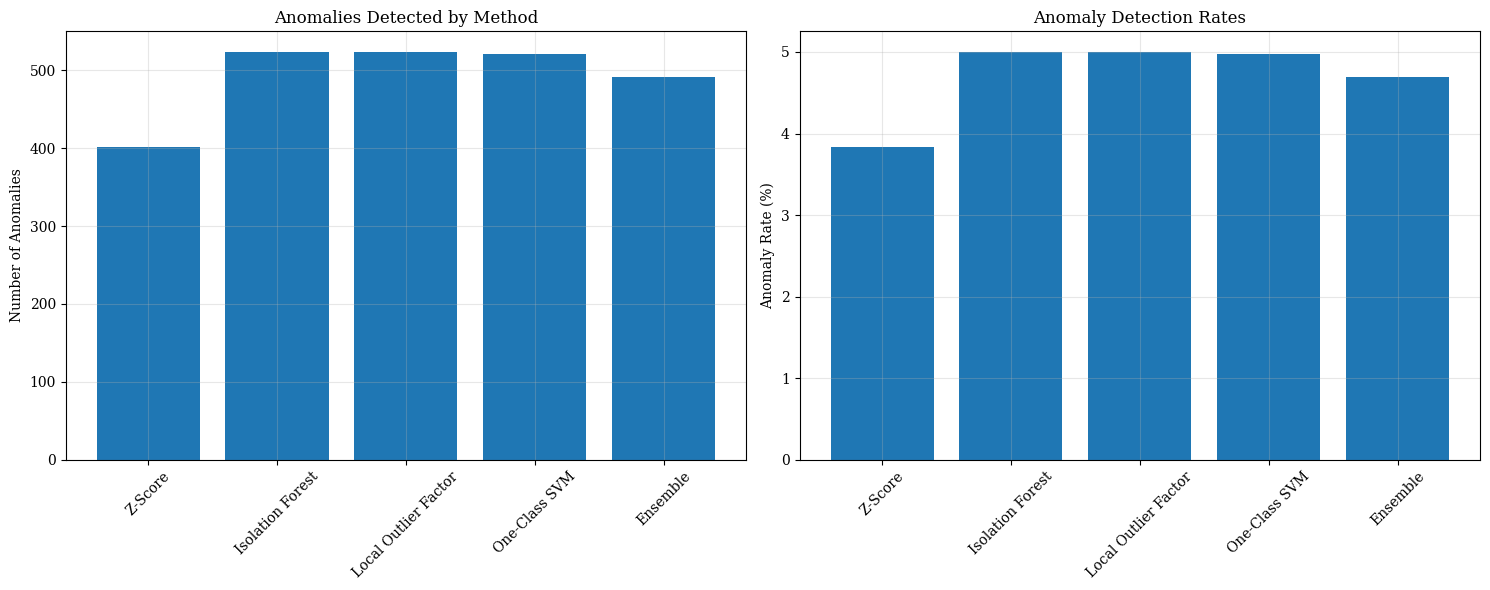

In [16]:
# Compare all anomaly detection methods
results_df = pd.DataFrame({
    'Method': ['Z-Score', 'Isolation Forest', 'Local Outlier Factor', 'One-Class SVM', 'Ensemble'],
    'Count': [zscore_count, iso_count, lof_count, svm_count, ensemble_count],
    'Rate': [zscore_rate, iso_rate, lof_rate, svm_rate, ensemble_rate]
})

print("\n=== ANOMALY DETECTION COMPARISON ===")
print(results_df.round(4))

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of anomaly counts
ax1.bar(results_df['Method'], results_df['Count'])
ax1.set_title('Anomalies Detected by Method')
ax1.set_ylabel('Number of Anomalies')
ax1.tick_params(axis='x', rotation=45)

# Bar plot of anomaly rates
ax2.bar(results_df['Method'], results_df['Rate'] * 100)
ax2.set_title('Anomaly Detection Rates')
ax2.set_ylabel('Anomaly Rate (%)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

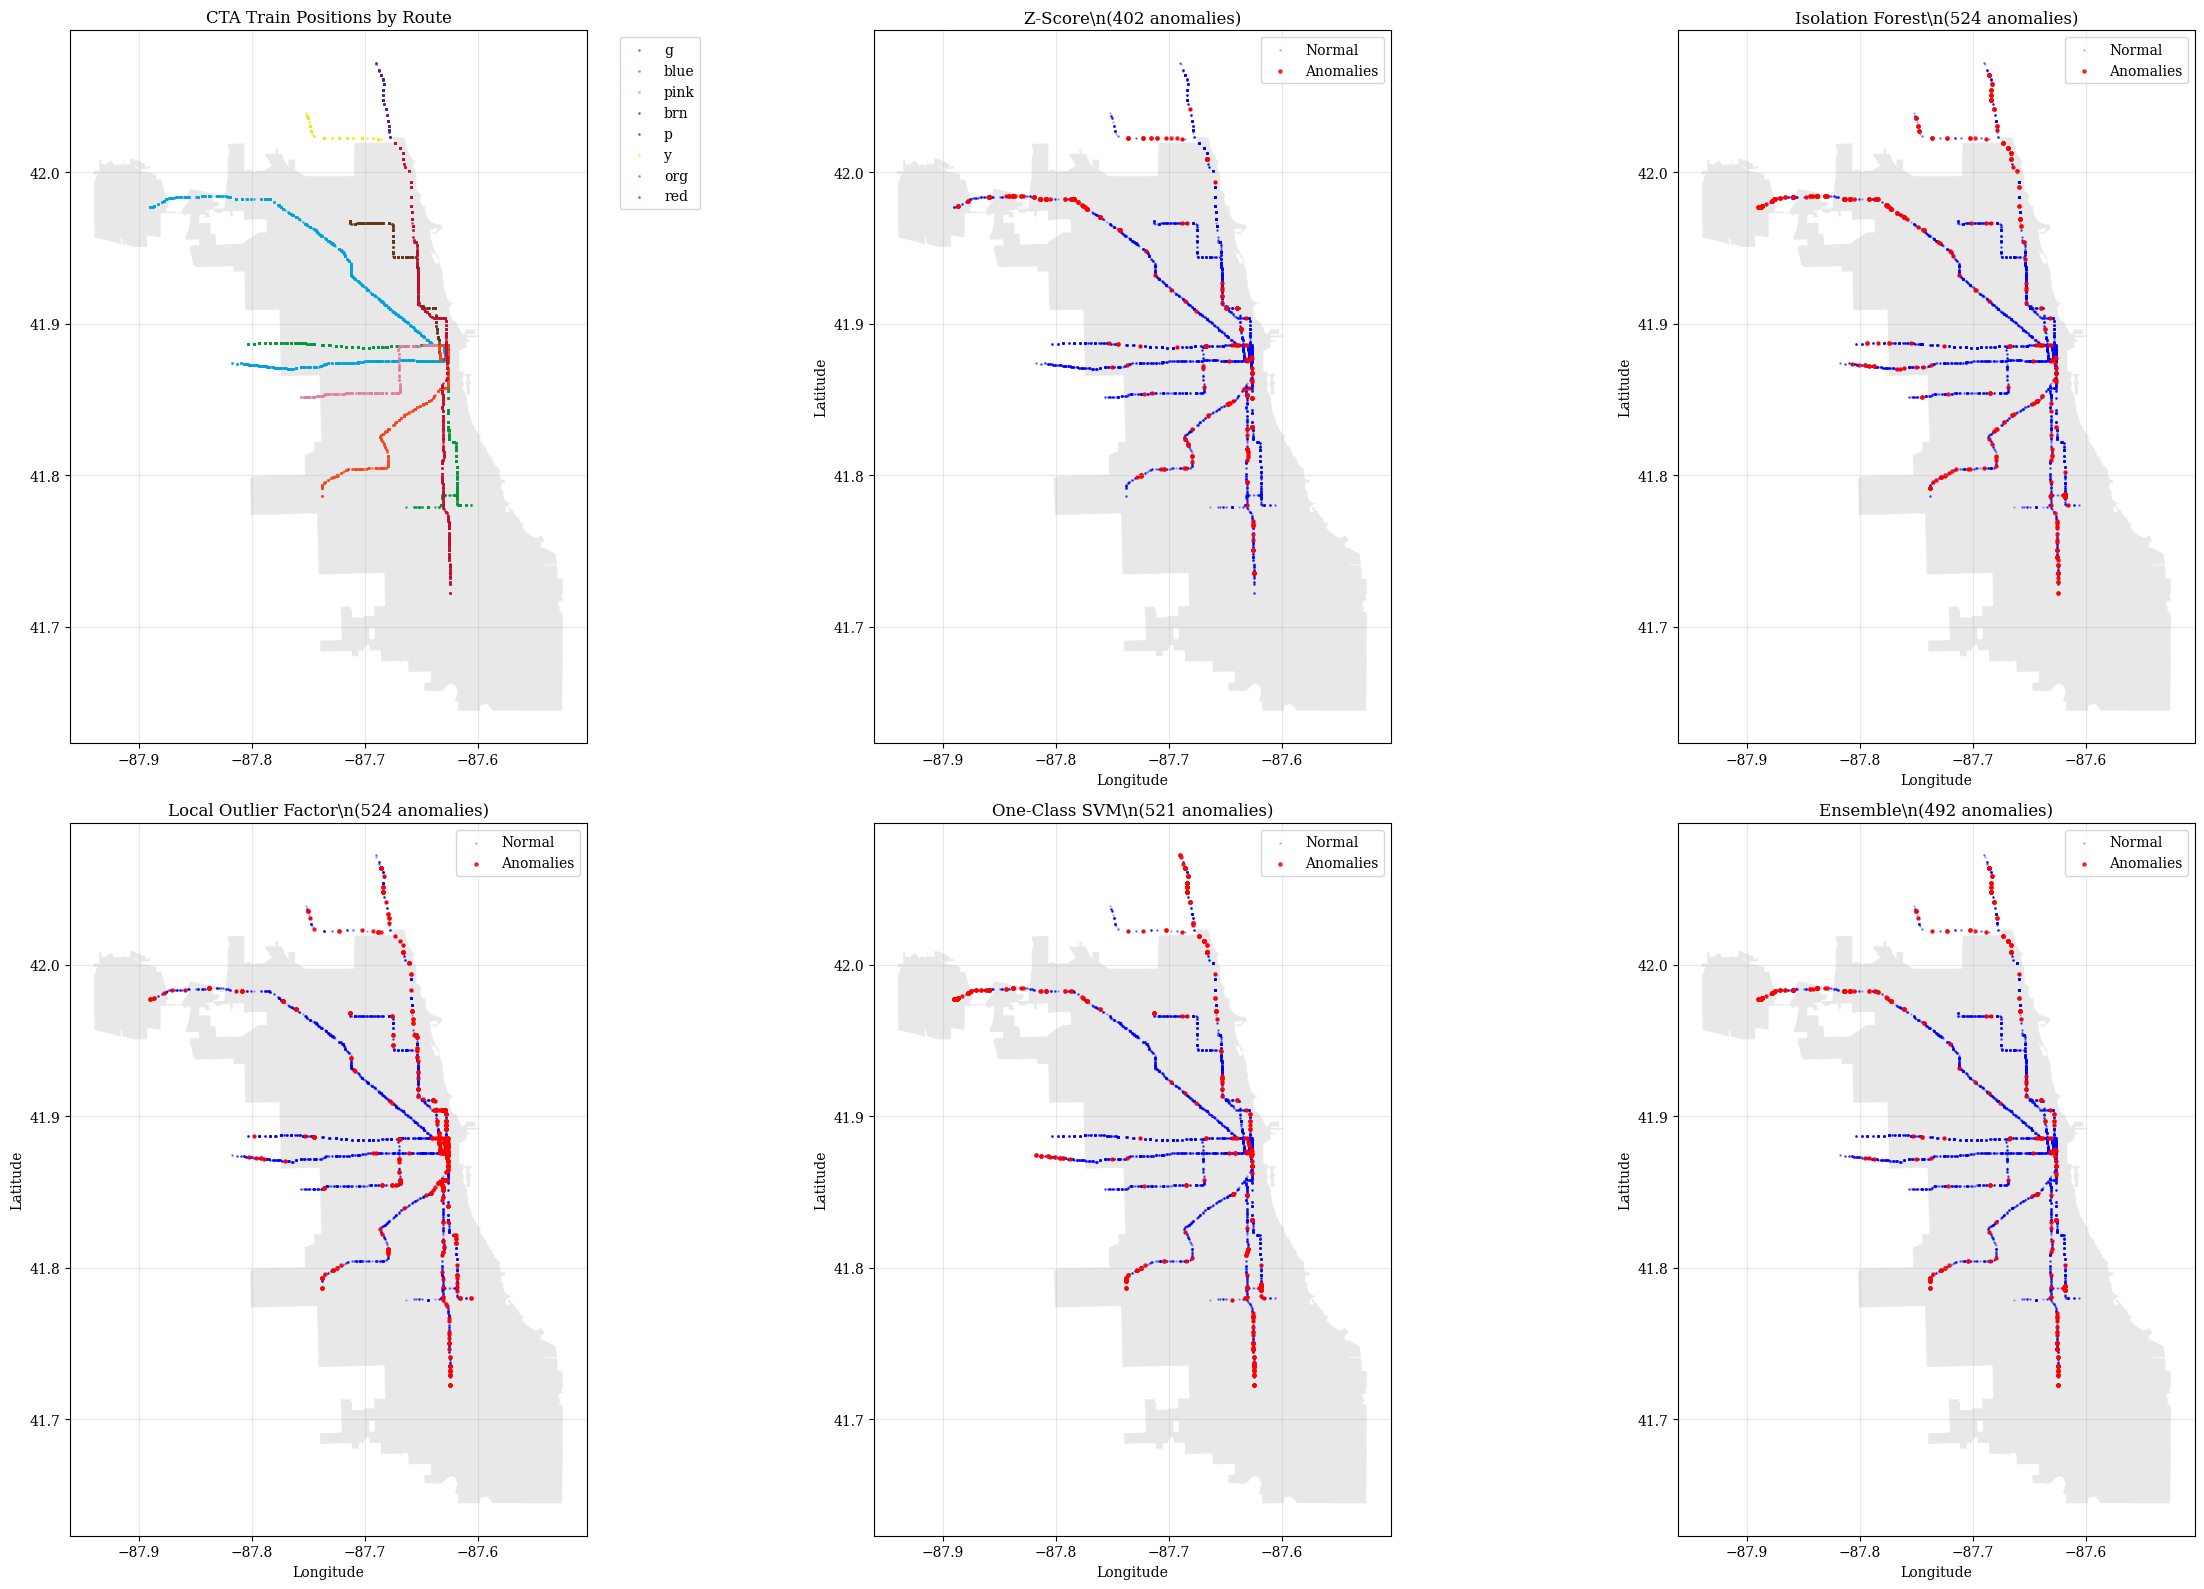

In [17]:
# Create comprehensive map visualization
if map_available:
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    axes = axes.flatten()
    
    # Plot 1: All train positions by route
    chicago_map.plot(ax=axes[0], color='lightgray', alpha=0.5)
    for route in df_features['route_name'].unique():
        route_data = df_features[df_features['route_name'] == route]
        color = CTA_LINE_COLORS.get(route, '#888888')  # Default gray for unknown routes
        axes[0].scatter(route_data['longitude'], route_data['latitude'], 
                       label=route, alpha=0.6, s=1, color=color)
    axes[0].set_title('CTA Train Positions by Route')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot different anomaly detection methods
    method_titles = ['Z-Score', 'Isolation Forest', 'Local Outlier Factor', 'One-Class SVM', 'Ensemble']
    method_cols = ['zscore_anomaly', 'iso_anomaly', 'lof_anomaly', 'svm_anomaly', 'ensemble_anomaly']
    
    for i, (method_col, title) in enumerate(zip(method_cols, method_titles)):
        ax = axes[i + 1]
        chicago_map.plot(ax=ax, color='lightgray', alpha=0.5)
        
        if method_col in df_features.columns and df_features[method_col].sum() > 0:
            normal_data = df_features[~df_features[method_col]]
            anomaly_data = df_features[df_features[method_col]]
            
            ax.scatter(normal_data['longitude'], normal_data['latitude'], 
                       c='blue', alpha=0.3, s=0.5, label='Normal')
            ax.scatter(anomaly_data['longitude'], anomaly_data['latitude'], 
                       c='red', alpha=0.8, s=5, label='Anomalies')
            
            ax.set_title(f'{title}\\n({anomaly_data.shape[0]:,} anomalies)')
        else:
            ax.set_title(f'{title}\\n(No anomalies detected)')
        
        ax.legend()
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()
else:
    print("Map visualization skipped - Chicago shapefile not available")

## 7. Anomaly Pattern Analysis

In [18]:
# Analyze high-confidence anomalies
if 'high_confidence_anomaly' in df_features.columns and df_features['high_confidence_anomaly'].sum() > 0:
    print("=== HIGH-CONFIDENCE ANOMALY EXAMPLES ===")
    high_conf_examples = df_features[df_features['high_confidence_anomaly']].nlargest(10, 'speed_kmh')
    print("Top 10 high-confidence speed anomalies:")
    display(high_conf_examples[['datetime', 'route_name', 'run_number', 'speed_kmh', 'is_delayed', 'hour_of_day']])
else:
    print("No high-confidence anomalies to analyze")

# Analyze patterns by route
if 'ensemble_anomaly' in df_features.columns:
    print("\n=== ANOMALY PATTERNS BY ROUTE ===")
    route_analysis = df_features.groupby('route_name').agg({
        'ensemble_anomaly': ['sum', 'mean'],
        'speed_kmh': ['mean', 'std'],
        'is_delayed': 'mean'
    }).round(3)
    
    route_analysis.columns = ['Anomaly_Count', 'Anomaly_Rate', 'Avg_Speed', 'Speed_Std', 'Delay_Rate']
    display(route_analysis)

# Analyze patterns by hour
if 'ensemble_anomaly' in df_features.columns:
    print("\n=== ANOMALY PATTERNS BY HOUR ===")
    hourly_analysis = df_features.groupby('hour_of_day').agg({
        'ensemble_anomaly': 'mean',
        'speed_kmh': 'mean',
        'is_delayed': 'mean'
    }).round(3)
    
    hourly_analysis.columns = ['Anomaly_Rate', 'Avg_Speed', 'Delay_Rate']
    display(hourly_analysis)

=== HIGH-CONFIDENCE ANOMALY EXAMPLES ===
Top 10 high-confidence speed anomalies:


,datetime,route_name,run_number,speed_kmh,is_delayed,hour_of_day
9302,2025-09-02 09:34:25,g,601,198.925500,0,9
2275,2025-09-01 19:25:48,blue,116,197.409947,0,19
10208,2025-09-02 09:43:27,pink,301,189.395495,0,9
9494,2025-09-02 09:36:26,brn,403,186.067793,0,9
10086,2025-09-02 09:42:26,blue,233,184.858610,0,9
1165,2025-09-01 19:09:24,blue,123,183.982562,0,19
3505,2025-09-01 19:43:12,blue,125,183.982562,0,19
1863,2025-09-01 19:19:39,blue,212,183.982562,0,19
103,2025-09-01 18:53:41,blue,214,183.982562,0,18
2706,2025-09-01 19:31:57,blue,115,181.015101,0,19



=== ANOMALY PATTERNS BY ROUTE ===


,Anomaly_Count,Anomaly_Rate,Avg_Speed,Speed_Std,Delay_Rate
route_name,,,,,
blue,189,0.065,31.357,29.126,0.001
brn,16,0.015,22.233,21.389,0.009
g,59,0.032,26.112,26.095,0.011
org,42,0.047,30.862,25.952,0.010
p,42,0.164,24.064,19.318,0.020
pink,12,0.014,25.632,24.040,0.003
red,121,0.048,28.050,25.171,0.010
y,11,0.133,46.957,35.387,0.000



=== ANOMALY PATTERNS BY HOUR ===


,Anomaly_Rate,Avg_Speed,Delay_Rate
hour_of_day,,,
9,0.114,13.441,0.020
18,0.039,33.625,0.000
19,0.028,31.895,0.004
20,0.031,31.657,0.005


## 8. Key Observations and Next Steps

### Key Observations:
1. **Data Quality**: Successfully processed CTA train data with comprehensive feature engineering
2. **Method Performance**: Different algorithms detect different types of anomalies
3. **Ensemble Approach**: Combining methods provides more reliable detection
4. **Temporal/Spatial Patterns**: Clear route and time-based anomaly patterns identified

### Method Comparison Results:
- **Z-Score**: Context-aware statistical outliers within route/time groups
- **Isolation Forest**: Multivariate outliers across all features
- **Local Outlier Factor**: Density-based anomalies considering local neighborhoods
- **One-Class SVM**: Complex decision boundary anomalies
- **Ensemble**: Most robust approach combining multiple methods

### Next Steps for Advanced Modeling:
1. **Use Ensemble Labels** as ground truth for supervised learning
2. **LightGBM Training** on ensemble anomaly labels
3. **LSTM Development** for sequence-based collective anomalies
4. **Conformal Prediction** for statistical confidence bounds
5. **Real-time API** development for live anomaly detection

### Model Deployment Pipeline:
- Train supervised models using ensemble labels
- Implement conformal prediction for uncertainty quantification
- Build FastAPI service for real-time predictions
- Create Streamlit dashboard for visualization
- Set up monitoring and alerting system